#Loading "6NX_1-blues_subsamples.dcd"; every 1-th frame
	 <mdtraj.Trajectory with 228 frames, 8683 atoms, 547 residues, and unitcells>
Selection: "resname LIG and not element H"
	Selected 11 atoms
	 [8656 8657 8658 8659 8660 8661 8662 8663 8664 8665 8666]

#Computing pairwise RMSD
	Processed frame 0

#Wards clustering pairwise RMSD
	Cluster 0 21
	Cluster 1 30
	Cluster 2 57
	Cluster 3 11
	Cluster 4 109

#Extracting Leaders...
	Cluster 0 [35 39  0  3  3]
	Cluster 1 [ 81  87 127 143 125]
	Cluster 2 [151  86  20  90  90]
	Cluster 3 [224  50 110 126 126]
	Cluster 4 [115 191 180  97  61]

#Assigning frames to clusters...
	Processed frame 0

#Assigned clusters...
	Cluster 0 [0, 1, 2, 3, 4, 5, 6, 7, 31, 32, 33, 34, 35, 36, 37, 39, 40, 216, 220, 221]
	Cluster 1 [11, 26, 28, 29, 58, 63, 65, 66, 69, 70, 71, 74, 78, 79, 81, 82, 83, 87, 91, 102, 109, 112, 113, 114, 117, 123, 124, 125, 127, 128, 134, 143, 144, 145, 148, 150, 155, 157, 161, 175, 177, 178, 179, 181, 183, 185, 194, 195, 213]
	Cluster 2

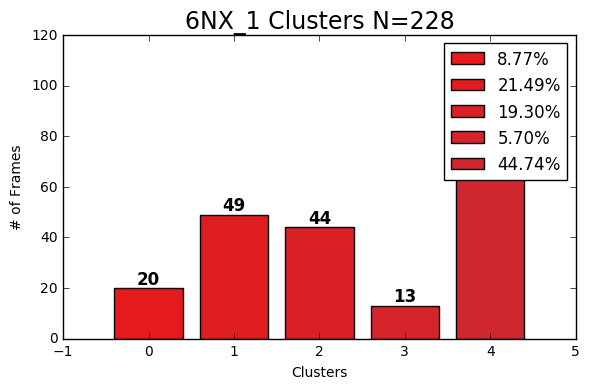

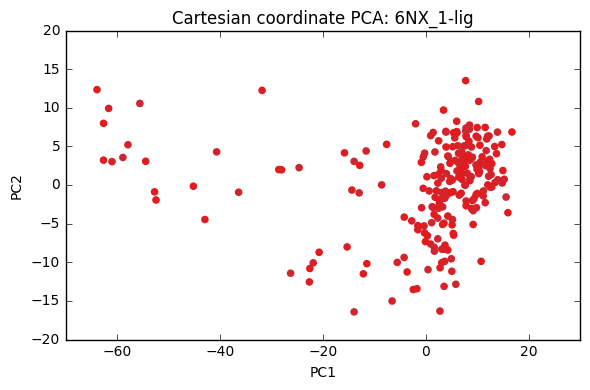

In [1]:
from __future__ import print_function
import random
from collections import defaultdict
import mdtraj as md
import numpy as np
import scipy.cluster.hierarchy
from sklearn.decomposition import PCA
from scipy.spatial.distance import squareform
import matplotlib.pyplot as plt
from time import time


class LigandMDTrajectory(object):
    def __init__(self, fname, fpath=None, top=None, stride=1,
                n_clusters=3, n_leaders_per_cluster=5,
                selection='resname LIG and not element H', **kwargs):
        self.fpath = fpath
        self.fname = fname
        self.n_clusters = n_clusters
        self.n_leaders_per_cluster = n_leaders_per_cluster
        self.stride = stride
        if top is not None:
            self.top = top

        print('#Loading "{}"; every {}-th frame'.format(self.fpath, self.stride))
        try:
            if self.top is not None:
                self.traj = md.load(fpath, stride=stride, top=self.top)
            else: self.traj = md.load(fpath, stride=stride)
            print('\t',self.traj)

            self.atom_indices = self.traj.topology.select(selection)
            print('Selection: "%s"' % selection)
            print('\tSelected', len(self.atom_indices), 'atoms')
            print( '\t', self.atom_indices )
        except Exception as e:
            raise Exception(e)

    def calcPairwiseRMSD(self, traj, atom_indices):
        """Compute the pairwise RMSD between all of the frames.
        This requires N^2 memory, which is why we might need to stride.
        """
        print("\n#Computing pairwise RMSD")

        distances = np.empty((traj.n_frames, traj.n_frames))
        for i in range(traj.n_frames):
            if i % 1000 == 0:
                print("\tProcessed frame", i)
            distances[i] = md.rmsd(traj, traj, i, atom_indices)
        return distances

    def wardsCluster(self, distances, n_clusters=5, **kwargs):
        """Finds a minimum threshold r so that the cophenetic distance between any two original observations in the same flat cluster is no more than r and no more than t flat clusters are formed.
        """
        print("\n#Wards clustering pairwise RMSD")
        linkage = scipy.cluster.hierarchy.ward(distances)
        labels = scipy.cluster.hierarchy.fcluster(linkage, t=n_clusters, criterion='maxclust')

        # Now, we need to extract n_leaders random samples from each of the clusters.
        # One way to do this is by building a map from each of the cluster labels to
        # the list of the indices of the traj confs which belong to it.
        mapping = defaultdict(lambda : [])
        for i, label in enumerate(labels):
            mapping[label-1].append(i)

        for k,v in mapping.items():
            print("\tCluster",k, len(v))
        return mapping

    def getLeaders(self, mapping, traj=None, n_leaders_per_cluster=5, **kwargs):
        """Iterate through the mapping and select n_leaders random samples from each list.
        Extract the conformation and append it to a new Trajectory.
        Use frame from trajectory otherwise it'll complain about no unit cell info
        """
        if traj is None: traj = self.traj
        leaders = traj[0]
        leader_labels = []
        print("\n#Extracting Leaders...")
        for label, indices in mapping.items():
            rand_idx = np.random.choice(indices, n_leaders_per_cluster)
            print("\tCluster", label, rand_idx)
            leaders = leaders.join(traj[rand_idx])
            leader_labels.extend([label] * n_leaders_per_cluster)
        # Now, Strip off the first frame.
        leaders = leaders[1:]
        return leaders, leader_labels

    def clusterAssignment(self, leaders, atom_indices, fpath, chunk=1, **kwargs):
        """Now our leaders trajectory contains a set of representitive conformations for each cluster. Consider leaders as fixed objects and iterate through every frame in our data set, assigning each frame to the cluster it's closest to.
        We take the simple approach here of computing the distance from each frame to each leader and assigning the frame to the cluster whose leader is closest.
        Note that this whole algorithm never requires having the entire dataset in memory at once
        """
        labels = []
        i = 0
        print("\n#Assigning frames to clusters...")
        opts = {'top':  self.top }
        for frame in md.iterload(fpath, chunk, **opts):
            if i % 1000 == 0:
                print("\tProcessed frame", i)
            lead_rmsd = md.rmsd(leaders, frame, 0, atom_indices)
            min_idx = np.argmin(lead_rmsd)
            labels.append(leader_labels[min_idx])
            i+=1
        labels = np.array(labels)

        clusters = defaultdict(lambda : [])
        for i, label in enumerate(labels):
            clusters[label].append(i)

        print("\n#Assigned clusters...")
        for k,v in clusters.items():
            print("\tCluster",k, v)
        return labels, clusters

    def calcPopulations(self, clusters, fname, title, savefig=True, **kwargs):
        N = 0
        count = {}
        freq = {}
        for k, v in clusters.items():
            count[k] = len(v)
            N+=len(v)

        print("\n#Calculating populations")
        freq = { key:"{0:.2f}%".format(int(val)/N * 100) for key, val in count.items()}
        for k,v in freq.items():
            print("\tCluster", k, v)

        fig, ax = plt.subplots()
        color = plt.cm.Set1(range(len(count)))
        bar = ax.bar(range(len(count)), count.values(),
                    align='center', color=color, label=freq.values())

        for i,rect in enumerate(bar.patches):
            plt.text(rect.get_x() + rect.get_width()/2, rect.get_height(), count[i], ha='center', va='bottom',
            fontdict={'weight': 'bold', 'size': 12})

        plt.title(title+' N=%s' %N, size=17)
        ax.set_ylabel('# of Frames')
        ax.set_xlabel('Clusters')
        plt.legend(bar, freq.values())
        plt.tight_layout()
        if savefig:
            outfname = '{}-bar_freq.png'.format(fname)
            plt.savefig(outfname)
        else:
            plt.show()

    def plot2DPCA(self, traj, labels, n_clusters, fname, **kwargs):

        if traj is None: traj = self.traj
        pca = PCA(n_components=2)
        reduced_cartesian = pca.fit_transform(traj.xyz.reshape(traj.n_frames, traj.n_atoms * 3))

        fig1 = plt.figure()
        ax1 = fig1.add_subplot(111)
        from matplotlib import colors
        color = plt.cm.Set1(range(n_clusters))
        norm = colors.Normalize(vmin=min(labels), vmax=max(labels))
        refscat = ax1.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1],  marker='o', norm=norm, color=color, alpha=1)

        plt.xlabel('PC1')
        plt.ylabel('PC2')
        plt.title('Cartesian coordinate PCA: %s' % fname)
        #plt.axis([-3,3,-3,3])
        plt.tight_layout()
        plt.show()

np.random.seed(0)
pdbfile = '6NX_1-top.pdb'
pdb = md.load(pdbfile)
top = pdb.topology
opt = { 'n_clusters' : 5,
        'n_leaders_per_cluster' : 5,
        'stride' : 1,
        'fname' : '6NX_1-lig',
        'fpath' : '6NX_1-blues_subsamples.dcd',
        'selection' : 'resname LIG and not element H',
        'top' : top }

if __name__ == "__main__":
    lig = LigandMDTrajectory(**opt)
    lig.traj[0].save('lig-first.pdb')
    distances = lig.calcPairwiseRMSD(lig.traj, lig.atom_indices)

    mapping = lig.wardsCluster(distances, **opt)
    leaders, leader_labels = lig.getLeaders(mapping, **opt)
    labels, clusters = lig.clusterAssignment(leaders, lig.atom_indices, chunk=opt['stride'], **opt)
    lig.calcPopulations(clusters, title='6NX_1 Clusters', savefig=True, **opt)
    lig.plot2DPCA(lig.traj, labels, **opt)
    leaders.save('6NX_1-leaders-5.nc')

In [2]:
from __future__ import print_function
import nglview #Embedded viewer

#Load test trajectory
traj = lig.traj

#Print info on what's in our trajectory
print(traj)

#Load MDTraj trajectory into view (it's also possible to visualize PDB's
# and a variety of other formats)
view = nglview.show_mdtraj(traj)

#Add space filling representation (optional)
view.clear_representations()
view.add_representation('spacefill', selection='resi 546' )
view.add_cartoon('protein')
#view.add_ball_and_stick('resi 546')


#Other things you might want to try
#
#view.add_licorice('not hydrogen') #Try 'not hydrogen' or 'all' for example
#view.add_ribbon()

view

<mdtraj.Trajectory with 228 frames, 8683 atoms, 547 residues, and unitcells>
